In [11]:
from itertools import cycle
import numpy as np
import pandas as pd
from scipy.stats import sem
from sklearn.linear_model import lasso_path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LassoCV
import matplotlib.gridspec as gridspec
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import ResidualsPlot
from joblib import dump, load

# Overview

This is the continuation of the analysis of Chicago apartments.com data from may of 2022. In the previous EDA using R,
the dataset was pre-processed and cleaned to be suitable for prediction. Then, a basic LASSO regression was performed on
the log transformed sqft. In the end, the linear model was not flexible enough to capture the trend in the data, since
the residual plot showed clear deviation as the sqft gets larger. Thus, more flexible models are attempted here to see if
better results can be achieved.

# Preparing the data

Most of the pre-processing work has already been done in the previous analysis. Thus, in this analysis the train and test
set from the previous analysis were loaded directly.

In [12]:
seed = 93
random.seed(seed)
np.random.seed(seed)
sqft_train = pd.read_csv("sqft_train.csv")
sqft_test = pd.read_csv("sqft_test.csv")
print(sqft_train.columns)

Index(['air.level', 'base.num', 'baths', 'beds', 'busi.level', 'covered.fee',
       'garage.fee', 'has.covered', 'has.garage', 'has.lot', 'has.street',
       'lot.fee', 'neighborhood', 'pet.allowed', 'pet.deposit', 'pet.fee',
       'pet.rent', 'shopping.num', 'sqft', 'traffic.level', 'zip', 'lat',
       'lng', 'has.parking', 'bed_count', 'bath_count', 'has.pub.elementary',
       'has.priv.elementary', 'has.pub.mid', 'has.cha.high', 'has.priv.high',
       'count.pub.high', 'pub.elt.mid', 'priv.elt.mid', 'has.cha.mid.high',
       'has.priv.mid.high', 'has.pub.mid.high', 'priv.el.hi', 'cha.elt.mid.hi',
       'priv.elt.mid.hi', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')


In the EDA, the raw sqft was skewed to the right, which indicates that there are some large apartments mixed together
with the regular sized apartments. By applying the log transformation, the relation was more linear in terms of some variables.
The total distribution was also made more symmetrical.

Here, the log transformation is also applied. Since the transformation shrinks the difference between the large and small
apartments, and in general makes a right skewed distribution more symmetrical, it can help reduce the effect of the extremities.
Finally, the least square estimator corresponds to the MLE for the signal + normal noise model. Thus, by pulling back the
large apartment, one can hope that it helps to transform the data closer to the assumed model.

Finally, since the data export did not encode the categorical variables, all the categorical variables are encoded into
binary form. The categorical bed_count and bath_count, while useful as an added correction term in the linear regression model,
are duplicate information for the tree based models. Thus, they are dropped as well.

In [13]:
sqft_train = sqft_train.drop(["bed_count", "bath_count"], axis=1)
sqft_test = sqft_test.drop(["bed_count", "bath_count"], axis=1)

sqft_tr_X = sqft_train.loc[:, sqft_train.columns != "sqft"]
sqft_tr_Y = sqft_train.loc[:, "sqft"]
log_tr_Y = np.log(sqft_train.loc[:, "sqft"])
sqft_ts_X = sqft_test.loc[:, sqft_test.columns != "sqft"]
sqft_ts_Y = sqft_test.loc[:, "sqft"]
log_ts_Y = np.log(sqft_test.loc[:, "sqft"])

categories = [
    'air.level', 'base.num', 'busi.level', 'has.covered', 'has.garage',
    'has.lot', 'has.street', 'neighborhood', 'pet.allowed',
    'traffic.level', 'has.parking', 'has.pub.elementary',
    'has.priv.elementary', 'has.pub.mid', 'has.cha.high',
    'has.priv.high', 'count.pub.high', 'pub.elt.mid',
    'priv.elt.mid', 'has.cha.mid.high', 'has.priv.mid.high', 'has.pub.mid.high',
    'priv.el.hi', 'cha.elt.mid.hi', 'priv.elt.mid.hi', "zip"
]

sqft_tr_X = pd.get_dummies(sqft_tr_X, columns=categories)
sqft_ts_X = pd.get_dummies(sqft_ts_X, columns=categories)

for c in sqft_tr_X.columns:
    if c not in sqft_ts_X.columns:
        sqft_ts_X[c] = 0
for c in sqft_ts_X.columns:
    if c not in sqft_tr_X.columns:
        sqft_tr_X[c] = 0

sqft_tr_X = sqft_tr_X.reindex(sorted(sqft_tr_X.columns), axis=1)
sqft_ts_X = sqft_ts_X.reindex(sorted(sqft_ts_X.columns), axis=1)

# Variable Selection

## LASSO

For this analysis, LASSO is still used for variable selection, and benchmarking. The tuning parameter for LASSO is
selected via 10-fold cross validation.

In [14]:
lasso_cv = LassoCV(max_iter=50000, cv=10, random_state=seed).fit(sqft_tr_X, log_tr_Y)

For the purpose of variable selection, the 1se rule is applied so that the least complex model within 1se of the best model
is selected.

In [15]:
lasso_se = sem(lasso_cv.mse_path_, axis=1)
lasso_mean = np.mean(lasso_cv.mse_path_, axis=1)
best_lasso = np.where(lasso_cv.alphas_ == lasso_cv.alpha_)[0][0]
best_lasso_se = lasso_se[best_lasso]
one_se_lasso = np.max(lasso_mean[lasso_mean <= lasso_mean[best_lasso] + best_lasso_se])
one_se_idx = np.where(lasso_mean == one_se_lasso)[0][0]
lasso_1se = Lasso(alpha=lasso_cv.alphas_[one_se_idx], max_iter=50000, random_state=seed).fit(sqft_tr_X, log_tr_Y)

The cross validation performance is plotted below. The top plot shows the average mse across the different folds vs the
tuning parameter. The bottom plot shows the number of non-zero coefficients for each tuning parameter. The optimal alpha
is marked with a dashed black line, while the 1se rule alpha is marked with the red line. From the previous analysis
it is clear the LASSO under-fits the data. It is reflected here as well since the CV performance is decreasing as the
complexity of the model decreases.

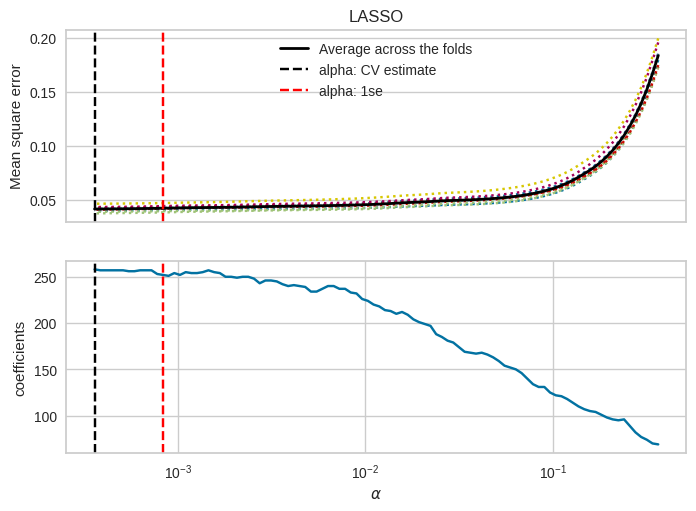

In [16]:
gs = gridspec.GridSpec(2,1)
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.axvline(lasso_cv.alphas_[one_se_idx], linestyle="--", color="red", label="alpha: 1se")
ax.set_ylabel("Mean square error")
ax.legend()
ax.set_title(
    "LASSO"
)
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(gs[1], sharex=ax)
alphas_lasso, coefs_lasso, _ = lasso_path(sqft_tr_X, sqft_tr_Y,
                                          alphas=lasso_cv.alphas_,
                                          max_iter=50000)
colors = cycle(["b", "r", "g", "c", "k"])
coef_count = []
for i, _ in enumerate(alphas_lasso):
    count = 0
    for coefs in coefs_lasso:
        if coefs[i] != 0:
            count += 1
    coef_count.append(count)

ax.semilogx(alphas_lasso, coef_count)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.axvline(lasso_cv.alphas_[one_se_idx], linestyle="--", color="red", label="alpha: 1se")
ax.set_ylabel("coefficients")
ax.set_xlabel(r"$\alpha$")
plt.show()


For the initial variable selection, the coefficients of the 1se rule LASSO is extracted, and the non-zero features are
selected.

In [17]:
coef_idx = lasso_1se.coef_ != 0
coefficients = lasso_1se.coef_[coef_idx]
coefficients = pd.Series(coefficients, sqft_tr_X.columns[coef_idx])
coefficients.abs().sort_values(ascending=False)
selected_tr_X = sqft_tr_X[coefficients.index]
selected_ts_X = sqft_ts_X[coefficients.index]

For benchmark purposes, the performance of the best LASSO estimator is presented. The mean and standard error for the
best LASSO estimator is given below.

In [18]:
pd.Series([lasso_mean[best_lasso], lasso_se[best_lasso]], ["mean_test_score", "std_test_score"])

mean_test_score    0.041829
std_test_score     0.000787
dtype: float64

The performance of the best LASSO estimator trained on the full training set is summarized below. Since this model did not
include any of the interactions in the previous analysis, it's performance is worse than the previous LASSO model. But, it
does serve as a baseline performance to look at more flexible models.

For LASSO, the MSE and MAE are similar between the test set and the training set, which shows that the model did not overfit
the data. This is probably due to the rigidity of the linear regression model. The test residual mean is negative, which suggests
that the model under-predicts the sqft on average.

In [19]:
def perf_summary(model, tr_x, ts_x, tr_y, ts_y):
    tr = np.exp(model.predict(tr_x))
    ts = np.exp(model.predict(ts_x))

    tr_mse = mean_squared_error(tr_y, tr)
    ts_mse = mean_squared_error(ts_y, ts)
    tr_mae = mean_absolute_error(tr_y, tr)
    ts_mae = mean_absolute_error(ts_y, ts)
    ts_mean = np.mean(ts - ts_y)
    ts_std = np.std(ts - ts_y)

    perf = pd.Series([tr_mse, ts_mse, tr_mae, ts_mae, ts_mean, ts_std],
                    index=["train.mse", "test.mse", "train.mae", "test.mae",
                           "test.resid.mean", "test.resid.stdev"])
    return perf


perf_summary(lasso_cv, sqft_tr_X, sqft_ts_X, sqft_tr_Y, sqft_ts_Y)

train.mse           49399.505027
test.mse            50178.229277
train.mae             139.991578
test.mae              143.571083
test.resid.mean       -17.486558
test.resid.stdev      223.321404
dtype: float64

## Random Forest
A random forest was fitted on the training set using the significant coefficients from 1se LASSO. The number of trees are
selected using cross validation. By default, essentially a full tree is fitted in the sklearn implementation. The number
of features per tree is calculated using the standard $\sqrt{n\_features}$ formula. The standard square loss is minimized.

In [20]:
random_forest = RandomForestRegressor(random_state=seed)
params = {
    "n_estimators": [1, 10, 25] + list(range(50, 301, 50))
}
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, log_tr_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': [1, 10, 25, 50, 100, 150, 200, 250,
                                          300]},
             scoring='neg_mean_squared_error')

The MSE of the log transformed response variable, and the number of trees across CV are plotted below. Although the
optimal value here is 300, it seems that by 10 estimators, the performance is already significantly improved from the
single full decision tree. By 100 estimators, the performance is already stagnant.

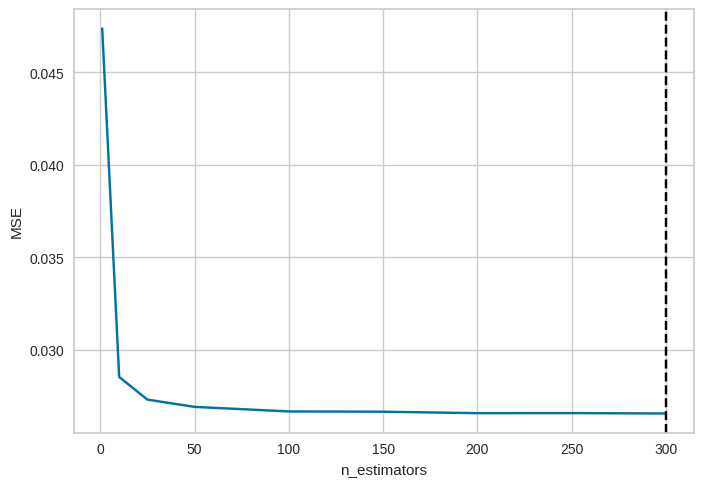

In [21]:
def plot_cv(cv_result, cv, param, x):
    plt.plot(x, -cv_result["mean_test_score"])
    plt.ylabel("MSE")
    plt.xlabel(param)
    plt.axvline(cv.best_params_[param],
            linestyle="--", color="black", label="best")
    plt.show()

plot_cv(pd.DataFrame(random_tree_cv.cv_results_), random_tree_cv, "n_estimators", [1, 10, 25] + list(range(50, 301, 50)))

Using the 300 tree random forest, the permutation variable importance is calculated. The values of each variable is
permuted 10 times, and the reduction in performance is recorded. The average of the reductions is then an indicator of
how important the variable is to the regression problem.

In [ ]:
best_rf = random_tree_cv.best_estimator_
rf_perm_imp = permutation_importance(best_rf, selected_tr_X, log_tr_Y,
                                     n_repeats=10, n_jobs=-1, random_state=seed)

The top 17 most important variable according to the RF is plotted below. Both the permutation importance, and also the
variable importance computed by the rf itself are included. The rf variable importance tends to be biased towards variables
that can be split multiple ways, while the permutation importance tends to share significance between correlated variables.
However, in this case, the set of top 6 variables which are clearly more important than others are the same between the two
variable importance measure. In particular, the location of the apartment, the number of bedrooms and bathrooms, and the
environment score PCs are important to predicting the sqft.

In [ ]:
gs = gridspec.GridSpec(1,2)
fig = plt.figure()
#fig.set_figheight(15)
#fig.set_figwidth(30)
ax = fig.add_subplot(gs[0])
rf_features = pd.Series(best_rf.feature_importances_,
                        selected_tr_X.columns).sort_values(ascending=True)[35:]
feature_pos = np.arange(len(rf_features))
ax.barh(feature_pos, rf_features)
plt.sca(ax)
plt.yticks(feature_pos, rf_features.index)
plt.title("RF Feature Importance")

ax = fig.add_subplot(gs[1])
rf_perm_imp_s = pd.Series(rf_perm_imp.importances_mean,
                        selected_tr_X.columns).sort_values(ascending=True)[35:]
ax.barh(feature_pos, rf_perm_imp_s)
plt.sca(ax)
plt.yticks(feature_pos, rf_perm_imp_s.index)
plt.title("Perm. Feature Importance")

For the final variable selection, the top 11 variables from both significance measures are picked. The rest of the
variables seem to not be helpful in predicting the sqft relatively according to the graph.

In [ ]:
relevant_features = set(rf_features.index[-11:])
relevant_features = relevant_features.union(set(rf_perm_imp_s.index[-11: ]))
selected_tr_X = selected_tr_X.loc[:, relevant_features]
selected_ts_X = selected_ts_X.loc[:, relevant_features]
print(relevant_features)

# Prediction
With the features selected above, several different models are fitted, and their results are reported below.

## Random Forest

Since removing the noise features increases the chance that a relevant feature would be picked by the rf, the model is
fitted again with the reduced feature set.

In [15]:
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, log_tr_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': [1, 10, 25, 50, 100, 150, 200, 250,
                                          300]},
             scoring='neg_mean_squared_error')

The CV performance of the optimal random forest is shown below. The complexity parameter is 200, which indicates that 200
full decision trees were averaged. The mean test score is around 0.014 lower than the LASSO on the log transformed response
variable. However, the standard deviation is higher than LASSO, which may be due to the fact that LASSO is more rigid
than random forest.

In [16]:
def best_cv(cv):
    cv_result = pd.DataFrame(cv.cv_results_)
    return cv_result, cv_result.loc[cv_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]


cv_rf_result, best_rf_result = best_cv(random_tree_cv)
best_rf_result

,params,mean_test_score,std_test_score
6,{'n_estimators': 200},-0.027138,0.001619


The MSE vs n_estimator across the cross validation test sets are plotted. Although 200 is the optimal parameter, it seems that
the performance already fully stabilizes at around 150 trees.

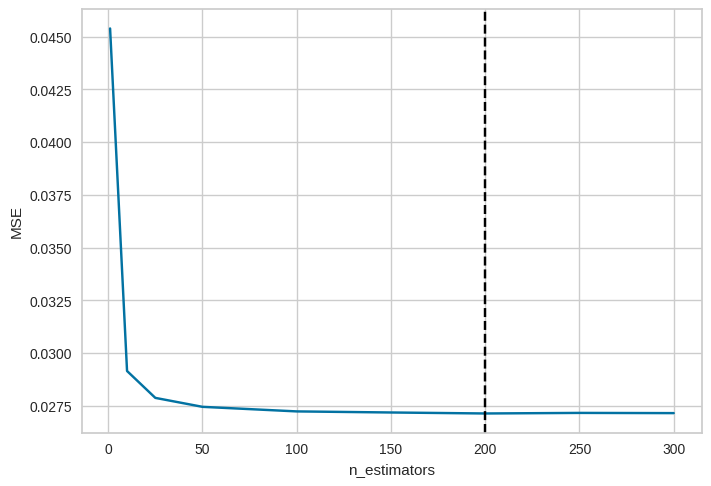

In [17]:
plot_cv(cv_rf_result, random_tree_cv, "n_estimators", params["n_estimators"])

The residuals of the log transformed sqft is plotted. There are no clear patterns in the residuals across the different
log sqfts. This is in contrast to the LASSO from the previous analysis where as the sqft increase, the model under-predicts
more. The QQ plot indicates that the residuals are not entirely normal. But, it's slightly skewed to the right, which
means that the model still under-predict a little. It also has a slight inverse S-shape, which indicates that it's a little bit over-dispersed compared to the normal distribution. This may be due to the fact that a lot of the apartments are concentrated around the prediction, but there are also a little more outliers that are further away from the prediction as compared to a normal residual.

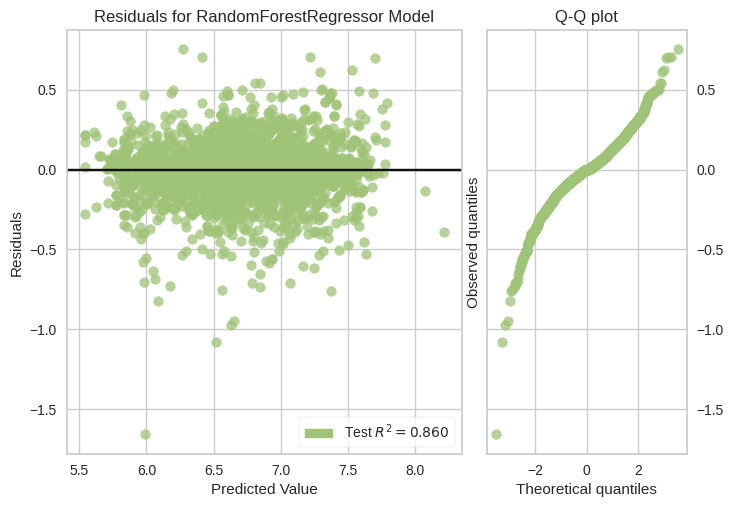

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
best_rf = random_tree_cv.best_estimator_
rs_plot = ResidualsPlot(best_rf, hist=False, qqplot=True)
rs_plot.score(selected_ts_X, log_ts_Y)
rs_plot.show()

The performance of the 200 tree random forest on the test set is summarized below. Both the mse and the mae increased notably
from the training set to the test set. The MAE on the test is 105 sqft, while the MSE is 32280. Both of those metrics
are lower than the training set performance of the LASSO mode during variable selection. It also out-performs the LASSO with
interractions from the EDA. The residual mean is around -16 sqft, which suggests that the estimator slightly under-predict
the data, which is consistent with the residual plot above. Although the residuals are not perfectly symmetrical, but it is
still likely the case that more than half of the test sqfts were within $-16 \pm 179$ sqfts of the prediction$

In [19]:
rf_perf = perf_summary(best_rf, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
rf_perf

train.mse           10401.128819
test.mse            32109.084729
train.mae              58.851728
test.mae              105.315586
test.resid.mean       -16.397372
test.resid.stdev      178.438255
dtype: float64

## Adaboost

Adaboost is also fitted on the training set. The algorithm incrementally optimizes the loss function using a base estimator 
by re-weighting the samples such that the next estimator focuses more on the bad outputs from the previous estimators. 
Then, it also does a weighted average of all the estimators with weights calculated to minimize the loss.

Here, the decision tree is used as a base estimator. Since the data is not linear, the max depth of the decision tree is 
increased to 25 so that it can successfully fit to the more challenging samples. The loss function is chosen to be the 
standard square loss, and the number of estimator is selected to be the one that performed best in cross validation. 

In [20]:
adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square")
adaboost_param = {
    "n_estimators": range(1, 101, 5)
}
adaboost_cv = GridSearchCV(adaboost, adaboost_param, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
adaboost_cv.fit(selected_tr_X, log_tr_Y)

GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                              random_state=93),
                                         loss='square', random_state=93),
             n_jobs=-1, param_grid={'n_estimators': range(1, 101, 5)},
             scoring='neg_mean_squared_error')

The cross validation performance for adaboost is shown below. The mean test mse is 0.0283, which is slightly higher
than the 0.0271 of random forest. The standard error is at 0.0014, which is lower than the 0.0016 of the
random forest. Since both the random forest and adaboost are fairly flexible, they have low bias as the test set performance
testifies. Thus, the better mean mse of the random forest may be due to the fact that it is designed to reduce the variance
of the predictor.

In [21]:
adaboost_cv_result, best_ada_res = best_cv(adaboost_cv)
best_ada_res

,params,mean_test_score,std_test_score
10,{'n_estimators': 51},-0.028772,0.001833


The CV curve is shown below. The optimal number of estimator was at 46. Unlike rf, Adaboost starts to
overfit to the data after around 55 trees, since the mse starts to increase.

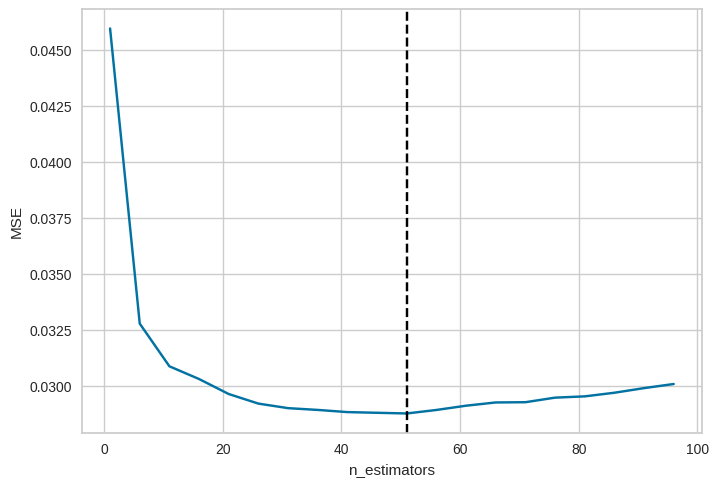

In [22]:
plot_cv(adaboost_cv_result, adaboost_cv, "n_estimators", range(1, 101, 5))

The residual plot of the Adaboost is similar to the random forest. There are no clear pattern in the plot, which 
suggest that the models were flexible enough to fit the trend of the data. The slight inverse S-shape also suggests an over-dispersed residual compared to normal.

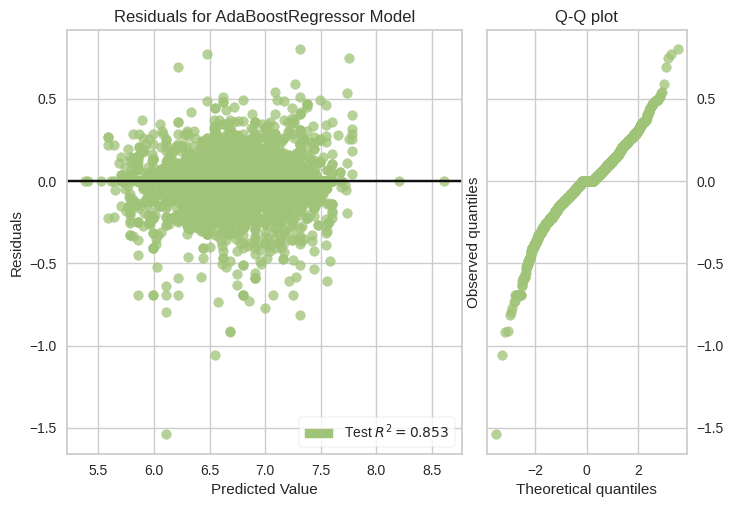

<AxesSubplot:title={'center':'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
best_ada = adaboost_cv.best_estimator_
rs_plot = ResidualsPlot(best_ada, hist=False, qqplot=True)
rs_plot.score(selected_ts_X, log_ts_Y)
rs_plot.show()

The performance of adaboost on the test set is summarized below. It's pretty similar to the performance of random forest.

In [24]:
ada_perf = perf_summary(best_ada, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse           10651.294416
test.mse            33570.619145
train.mae              56.522202
test.mae              105.726803
test.resid.mean       -21.382862
test.resid.stdev      181.970856
dtype: float64

## Bagged Adaboost

By explicitly reducing the variance of Adaboost via bagging, the performance may be improved further.
Since cross validation was already performed for Adaboost, the same parameters are used here. The number of estimators and the
maximum number of feature to consider for each estimator are selected via cross validation.

In [25]:
bag_ada_params = {
    "n_estimators": range(1, 101, 10),
    "max_features": range(1, 14)
}
bag_ada_base = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square", n_estimators=46)
bag_ada = BaggingRegressor(bag_ada_base, random_state=seed)
bag_ada_cv = GridSearchCV(estimator=bag_ada, param_grid=bag_ada_params, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
bag_ada_cv.fit(selected_tr_X, log_tr_Y)

/home/sdai/PycharmProjects/Analysis/venv37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                                              random_state=93),
                                                                         loss='square',
                                                                         n_estimators=46,
                                                                         random_state=93),
                                        random_state=93),
             n_jobs=-1,
             param_grid={'max_features': range(1, 14),
                         'n_estimators': range(1, 101, 10)},
             scoring='neg_mean_squared_error')

It turned out that 61 estimators, each trained on a maximum of 12 features achieved the optimal mse. From the CV
result, bagging indeed improved the performance of Adaboost. The bagged estimator is able to achieve a mean test 
score of 0.0262, which is lower than both the rf at 0.0271 and adaboost at 0.0283. The standard error for the
mean test score at 0.0015 is a little higher than the 0.0014 of the vanilla adaboost.

In [26]:
bag_ada_cv_cv_result, best_bag_ada = best_cv(bag_ada_cv)
best_bag_ada

,params,mean_test_score,std_test_score
119,"{'max_features': 12, 'n_estimators': 91}",-0.026183,0.001596


The residual plot is very similar to the random forest one. The qq-plot also shows the slight skew and the inverse-S shape. Thus, it seems to slightly under-predict the data, with some outliers that are relatively far away from the prediction.

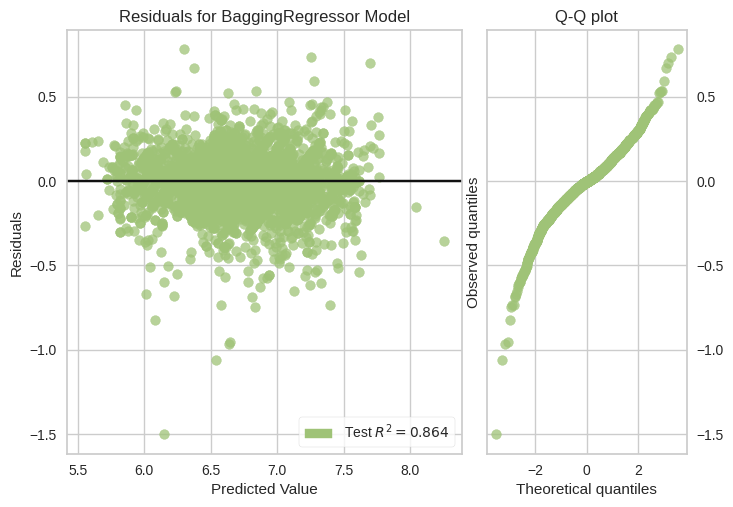

<AxesSubplot:title={'center':'Residuals for BaggingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
best_ada_bag = bag_ada_cv.best_estimator_
rs_plot = ResidualsPlot(best_ada_bag, hist=False, qqplot=True)
rs_plot.score(selected_ts_X, log_ts_Y)
rs_plot.show()

The performance of the bagged adaboost on the test set is summarized here. It achieved a similar test MAE as
the random forest. It is a few sqft more biased towards under-predicting on the test set, but the standard 
deviation is the same as the random forest. The test MSE is better than both the non-bagged adaboost and random forest.

In [28]:
ada_perf = perf_summary(best_ada_bag, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse           12306.243579
test.mse            31686.023006
train.mae              67.948787
test.mae              106.028850
test.resid.mean       -22.729720
test.resid.stdev      176.548528
dtype: float64

## Stacked Estimator

A final stacked estimator consisting of the random forest, plain adaboost, and bagged adaboost are fitted to the 
training set. The final prediction is the output of a ridge regression on the output of the three base estimators. 
Thus, it can balance out the performance of the different estimators to achieve a weighted averge of all 3 estimator 
with less variance and better accuracy. As usual, the tuning parameter is set via cross validation.

In [29]:
estimators = {
    "rf": best_rf,
    "ada": best_ada,
    "bag_ada": best_ada_bag
}
stacking_ridge = StackingRegressor(estimators=list(estimators.items()), cv=10,
                                   n_jobs=-1, passthrough=False)

The cross validation performance of the stacked estimators is shown below. The ensemble estimator achieved the lowest 
mean test error and standard error of all the estimators so far. Thus, the stacking was able to improve the 
performance of the estimators.

In [30]:
stacking_cv = cross_val_score(stacking_ridge, selected_tr_X, log_tr_Y,
                              cv=10, scoring="neg_mean_squared_error")
pd.Series([stacking_cv.mean(), stacking_cv.std()], ["cv_mean", "cv_std"])

cv_mean   -0.026096
cv_std     0.001508
dtype: float64

The residual/qq plot of the stacked predictor is almost identical to the random forest and bagged adaboost. Thus, 
stacking was not able to address the skew and outlier issue from earlier.

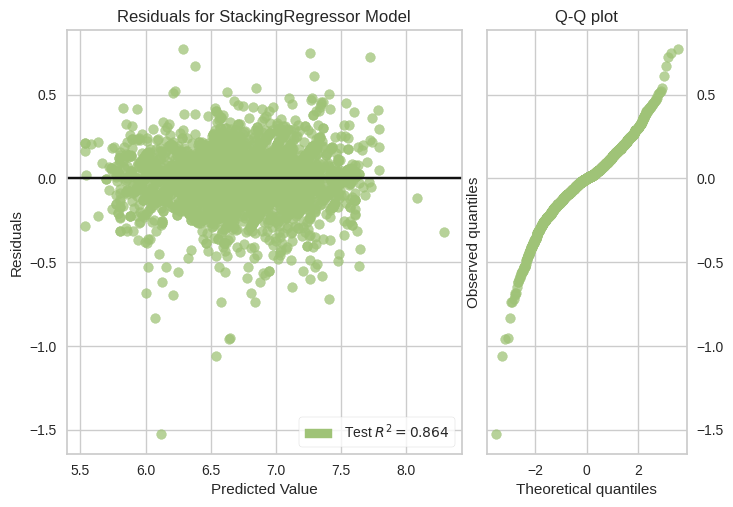

<AxesSubplot:title={'center':'Residuals for StackingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [31]:
stacking_ridge.fit(selected_tr_X, log_tr_Y)
rs_plot = ResidualsPlot(stacking_ridge, hist=False, qqplot=True)
rs_plot.score(selected_ts_X, log_ts_Y)
rs_plot.show()

The stacked predictor achieved the lowerst test MSE of all the tried predictors. It also achieved the lowest standard 
deviation of the residuals. However, the test MAE and test bias are similar to the other predictors.

In [32]:
stacking_perf = perf_summary(stacking_ridge, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
stacking_perf

train.mse           11229.503502
test.mse            31134.775854
train.mae              65.451096
test.mae              105.407463
test.resid.mean       -16.595283
test.resid.stdev      175.668359
dtype: float64

# Conclusion

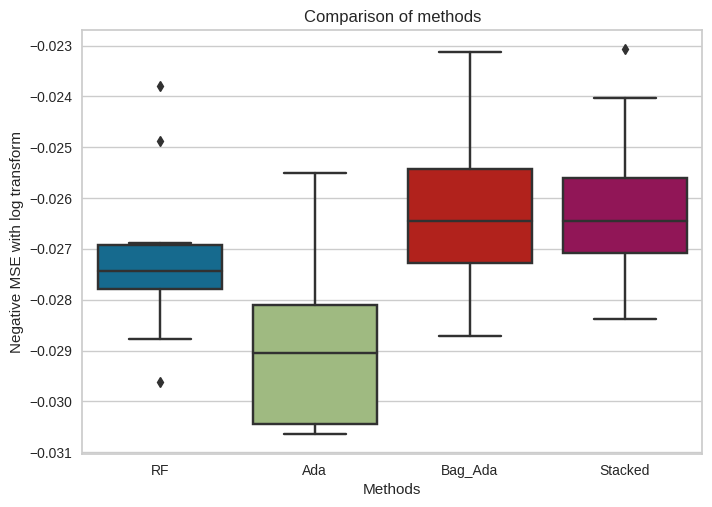

In [33]:
rf_df = cv_rf_result.loc[cv_rf_result.rank_test_score == 1, ].iloc[:, 6:16].transpose().set_axis(["RF"], axis=1, inplace=False)
ada_df = adaboost_cv_result.loc[adaboost_cv_result.rank_test_score == 1, ].iloc[:, 6:16].transpose().set_axis(["Ada"], axis=1, inplace=False)
bag_ada_df = bag_ada_cv_cv_result.loc[bag_ada_cv_cv_result.rank_test_score == 1, ].iloc[:, 7:17].transpose().set_axis(["Bag_Ada"], axis=1, inplace=False)
combined_temp = rf_df.join(ada_df).join(bag_ada_df).reset_index(drop=True)
combined_temp = combined_temp.join(pd.DataFrame(stacking_cv).set_axis(["Stacked"], axis=1, inplace=False))
fig = sns.boxplot(x="variable", y="value", data=pd.melt(combined_temp))
plt.xlabel("Methods")
plt.ylabel("Negative MSE with log transform")
plt.title("Comparison of methods")
plt.show()

From the boxplot above as well as the individual summaries under each section, the mean/median stacked predictor surpasses all the other ones excluding LASSO. It also has a relatively narrow boxplot, which
indicates a relatively low variance in performance during cross validation. Thus, the performance of the stacked predictor is relatively stable as well. A close second in the mean/median CV performance is the bagged
adaboost, which has a low bias due to the boosting and a reduced variance due to the bagging. Finally, the random forest has a narrow IQR in the cross validation scores. This may be also due to the fact that a random
forest explicitly tries to increase robustness via bagging and randomly selecting features.

Since the stacked predictor had the best performance in cross validation with a modest variance, it will be used to better fill in the square feet information on incomplete records. All of the required predictors would be
fitted on the whole dataset where square feet is not absent. The hyper-parameters will be picked via cross validation as usual. Then, the square feet for the missing records will be calculated.


In [26]:
full_set = pd.concat([selected_tr_X, selected_ts_X], ignore_index=True)
full_log_sqft = pd.concat([log_tr_Y, log_ts_Y], ignore_index=True)
full_set.columns

Index(['lng', 'PC4', 'garage.fee', 'PC1', 'pub.elt.mid_1',
       'pet.allowed_disallowed', 'shopping.num', 'pub.elt.mid_0', 'beds',
       'pet.fee', 'PC2', 'baths', 'pet.rent'],
      dtype='object')

In [ ]:
rf_mod = RandomForestRegressor(n_estimators=200, random_state=seed).fit(full_set, full_log_sqft)
adaboost_mod = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square", n_estimators=41).fit(full_set, full_log_sqft)
bag_ada_mod = BaggingRegressor(bag_ada_base, random_state=seed, n_estimators=61, max_features=12).fit(full_set, full_log_sqft)

estimators = {
    "rf": rf_mod,
    "ada": adaboost_mod,
    "bag_ada": bag_ada_mod
}
stacking_ridge = StackingRegressor(estimators=list(estimators.items()), cv=10,
                                   n_jobs=-1, passthrough=False).fit(full_set, full_log_sqft)
dump(stacking_ridge, "final_sqft_mod.joblib")
